# Анализ клиентской базы e-commerce с помощью RFM-анализ и кластеризации

## Описание проекта

Анализ клиентской базы интернет-магазина на основе синтетического датасета e-commerce транзакций. Проект направлен на сегментацию клиентов и выявление поведенческих паттернов для оптимизации маркетинговых стратегий.

**Датасет:** [E-commerce Sales Transactions Dataset](https://www.kaggle.com/datasets/miadul/e-commerce-sales-transactions-dataset/data)  
**Размер данных:** 34,500 транзакций, 17 признаков

Признаки: 
- `order_id` - Уникальный идентификатор заказа
- `customer_id` - Уникальный идентификатор клиента
- `product_id` - Уникальный идентификатор товара
- `category` - Категория товара
- `price` - Цена за единицу
- `discount` - Примененная скидка (%)
- `quantity` - Количество купленных товаров
- `payment_method` - Способ оплаты
- `order_date` - Дата заказа
- `delivery_time_days` - Время доставки в днях
- `region` - Географический регион клиента
- `returned` - Был ли товар возвращен
- `total_amount` - Итоговая сумма после скидок
- `shipping_cost` - Стоимость доставки
- `profit_margin` - Прибыль с заказа
- `customer_age` - Возраст клиента

## Цели проекта

- Провести комплексный анализ продаж и клиентского поведения
- Реализовать RFM-анализ для сегментации клиентской базы
- Выявить ключевые сегменты клиентов и разработать рекомендации
- Определить клиентов с риском оттока и предложить меры по их удержанию

## Используемые инструменты

- **Python** - основной язык программирования
- **Pandas, NumPy** - обработка и анализ данных
- **Matplotlib, Seaborn** - визуализация результатов
- **Scikit-learn** - машинное обучение и кластеризация
- **Jupyter Notebook** - среда разработки

## Ожидаемые результаты

- Сегментация клиентов на основе поведения
- Рекомендации по удержанию ценных клиентов
- Выявление факторов, влияющих на отток клиентов
- Оптимизация маркетинговых кампаний
- Улучшение клиентского опыта и увеличение LTV

# Этап 1: Предобработка данных 

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('ecommerce_sales_34500.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34500 entries, 0 to 34499
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            34500 non-null  object 
 1   customer_id         34500 non-null  object 
 2   product_id          34500 non-null  object 
 3   category            34500 non-null  object 
 4   price               34500 non-null  float64
 5   discount            34500 non-null  float64
 6   quantity            34500 non-null  int64  
 7   payment_method      34500 non-null  object 
 8   order_date          34500 non-null  object 
 9   delivery_time_days  34500 non-null  int64  
 10  region              34500 non-null  object 
 11  returned            34500 non-null  object 
 12  total_amount        34500 non-null  float64
 13  shipping_cost       34500 non-null  float64
 14  profit_margin       34500 non-null  float64
 15  customer_age        34500 non-null  int64  
 16  cust

Можем заметить, что нету пропущенных значений

In [7]:
df['order_id'].duplicated().sum()

np.int64(0)

Дубликаты не обнаружены

In [9]:
# Преобразуем order_date в datetime
df['order_date'] = pd.to_datetime(df['order_date'])

In [10]:
df.describe()

,price,discount,quantity,order_date,delivery_time_days,total_amount,shipping_cost,profit_margin,customer_age
count,34500.000000,34500.000000,34500.000000,34500,34500.000000,34500.000000,34500.000000,34500.000000,34500.000000
mean,119.391632,0.049291,1.490725,2024-09-13 13:39:17.843478272,4.814203,170.008494,6.152120,28.116505,43.474377
min,1.010000,0.000000,1.000000,2023-09-12 00:00:00,3.000000,0.820000,0.000000,-6.200000,18.000000
25%,16.690000,0.000000,1.000000,2024-03-14 00:00:00,4.000000,19.710000,4.420000,1.500000,31.000000
50%,45.660000,0.000000,1.000000,2024-09-16 00:00:00,5.000000,56.820000,6.090000,10.550000,43.000000
75%,130.950000,0.100000,2.000000,2025-03-17 00:00:00,6.000000,168.530000,7.830000,33.132500,56.000000
max,2930.470000,0.300000,5.000000,2025-09-11 00:00:00,13.000000,12931.800000,15.650000,1536.170000,69.000000
std,195.620477,0.069894,0.932270,NaN,1.242141,357.503014,2.389539,53.352947,14.980682


**Наблюдения из описательной статистики:**

- **Сильный разброс значений** наблюдается в колонках:
  - `delivery_time_days` - время доставки
  - `total_amount` - итоговая сумма
  - `shipping_cost` - стоимость доставки
  - `profit_margin` - прибыль

- **Потенциальные аномалии:**
  - Разница между 75% квартилем и максимальным значением
  - В `total_amount` и `shipping_cost` это может быть связано с редкими дорогими товарами
  - В `delivery_time_days` и `profit_margin` требуют внимания экстремально высокие значения

In [12]:
df['delivery_time_days'].value_counts()

delivery_time_days
5     10296
4     10094
6      5961
3      4907
7      2400
8       663
9       152
10       25
13        1
12        1
Name: count, dtype: int64

In [13]:
df[df['delivery_time_days'] >= 12]

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
1708,O101708,C10832,P237575,Fashion,22.14,0.0,2,Credit Card,2024-04-14,13,East,No,44.28,7.21,8.29,48,Female
7575,O107575,C14524,P223337,Fashion,7.46,0.0,1,Credit Card,2023-11-12,12,East,No,7.46,3.89,-1.28,39,Female


**Обнаружены 2 аномалии доставки** - 12 и 13 дней. 

Оба заказа:
- Небольшие суммы (7.46€ и 44.28€)
- Категория Fashion, регион East
- Без скидок, не возвращались
- Возможны логистические сбои

In [15]:
df['profit_margin'].sort_values().tail(10)

24728     727.35
16950     734.88
20748     765.28
17363     765.85
13451     880.52
6024     1004.97
33055    1112.25
27798    1341.91
7705     1392.96
20765    1536.17
Name: profit_margin, dtype: float64

In [16]:
df[df['profit_margin'] > 1000]

,order_id,customer_id,product_id,category,price,discount,quantity,payment_method,order_date,delivery_time_days,region,returned,total_amount,shipping_cost,profit_margin,customer_age,customer_gender
6024,O106024,C10609,P218759,Home,726.76,0.0,5,Debit Card,2025-09-04,3,Central,No,3633.80,12.49,1004.97,28,Female
7705,O107705,C13565,P242326,Electronics,2930.47,0.0,4,UPI,2024-04-13,4,West,No,11721.88,13.67,1392.96,22,Male
20765,O120765,C16655,P217031,Electronics,2586.36,0.0,5,Debit Card,2024-02-22,5,West,No,12931.80,15.65,1536.17,28,Male
27798,O127798,C15379,P224743,Electronics,2259.66,0.0,5,PayPal,2024-12-11,3,Central,No,11298.30,13.89,1341.91,67,Male
33055,O133055,C12026,P247897,Home,802.08,0.0,5,Debit Card,2024-09-07,4,Central,No,4010.40,10.66,1112.25,66,Male


**Анализ экстремальных значений profit_margin:**

**Найдено 10 заказов** с прибылью свыше 700€ (максимум 1536€)

**Характеристики заказов:**
- Крупные покупки (количество товаров: 4-5 штук)
- Премиальные категории: Electronics и Home
- Отсутствие скидок (0% discount)
- Нулевой уровень возвратов
- Нормальное время доставки (3-5 дней)

**Вывод:** Экстремальные значения `profit_margin` не являются аномалиями - это закономерно прибыльные заказы дорогих товаров в больших количествах, что отражает нормальную бизнес-практику.

In [18]:
# Агрегация данных по клиентам
customer_agg = df.groupby('customer_id').agg({
    'order_id': 'count',  # Количество заказов
    'total_amount': 'sum',  # Общая сумма покупок
    'profit_margin': 'sum',  # Общая прибыль
    'quantity': 'sum',  # Общее количество товаров
    'discount': 'mean',  # Средняя скидка
    'returned': lambda x: (x == 'Yes').sum(),  # Количество возвратов
    'shipping_cost': 'sum',  # Общая стоимость доставки
    'delivery_time_days': 'mean',  # Среднее время доставки
    'category': lambda x: x.mode()[0],  # Самая частая категория
    'payment_method': lambda x: x.mode()[0],  # Предпочитаемый способ оплаты
    'region': lambda x: x.mode()[0],  # Основной регион
    'customer_age': 'first'  # Возраст (берем первое встретившееся значение)
}).reset_index()

# 2. Переименуем колонки для понятности
customer_agg.columns = [
    'customer_id',
    'total_orders', # Общее количество заказов
    'total_spent', # Сумма всех покупок
    'total_profit', # Общая прибыль от клиента
    'total_items', # Всего купленных товаров
    'avg_discount', # Средний размер скидки
    'returns_count', # Количество возвратов
    'total_shipping_cost', # Затраты на доставку
    'avg_delivery_time', # Среднее время доставки
    'favorite_category', # Любимая категория товаров
    'preferred_payment', # Предпочитаемый способ оплаты
    'main_region', # Основной регион покупок
    'customer_age' # Возраст клиента
]

# 3. Дополнительные расчеты
customer_agg['avg_order_value'] = customer_agg['total_spent'] / customer_agg['total_orders']  # Средний чек
customer_agg['return_rate'] = customer_agg['returns_count'] / customer_agg['total_orders']    # Процент возвратов

customer_agg.head()

,customer_id,total_orders,total_spent,total_profit,total_items,avg_discount,returns_count,total_shipping_cost,avg_delivery_time,favorite_category,preferred_payment,main_region,customer_age,avg_order_value,return_rate
0,C10000,2,210.58,19.71,2,0.075000,0,13.18,4.000000,Electronics,Debit Card,North,54,105.290000,0.0
1,C10001,5,3246.02,493.90,12,0.070000,0,45.50,4.800000,Electronics,Credit Card,North,24,649.204000,0.0
2,C10002,5,216.85,31.39,6,0.130000,0,31.02,5.200000,Toys,Debit Card,East,51,43.370000,0.0
3,C10003,3,154.30,26.28,3,0.016667,0,16.72,5.000000,Home,Debit Card,Central,38,51.433333,0.0
4,C10004,3,716.99,82.70,5,0.000000,0,22.54,5.666667,Electronics,Credit Card,East,22,238.996667,0.0


# Этап 2: Разведочный анализ данных

### АНАЛИЗ ВРЕМЕННЫХ ТРЕНДОВ ПРОДАЖ

In [21]:
# Создаем месячный агрегат продаж
monthly_sales = df.groupby(df['order_date'].dt.to_period('M')).agg({
    'total_amount': 'sum',
    'order_id': 'count',
    'profit_margin': 'sum'}).reset_index()

# Преобразуем периоды в даты для визуализации
monthly_sales['order_date'] = monthly_sales['order_date'].dt.to_timestamp()

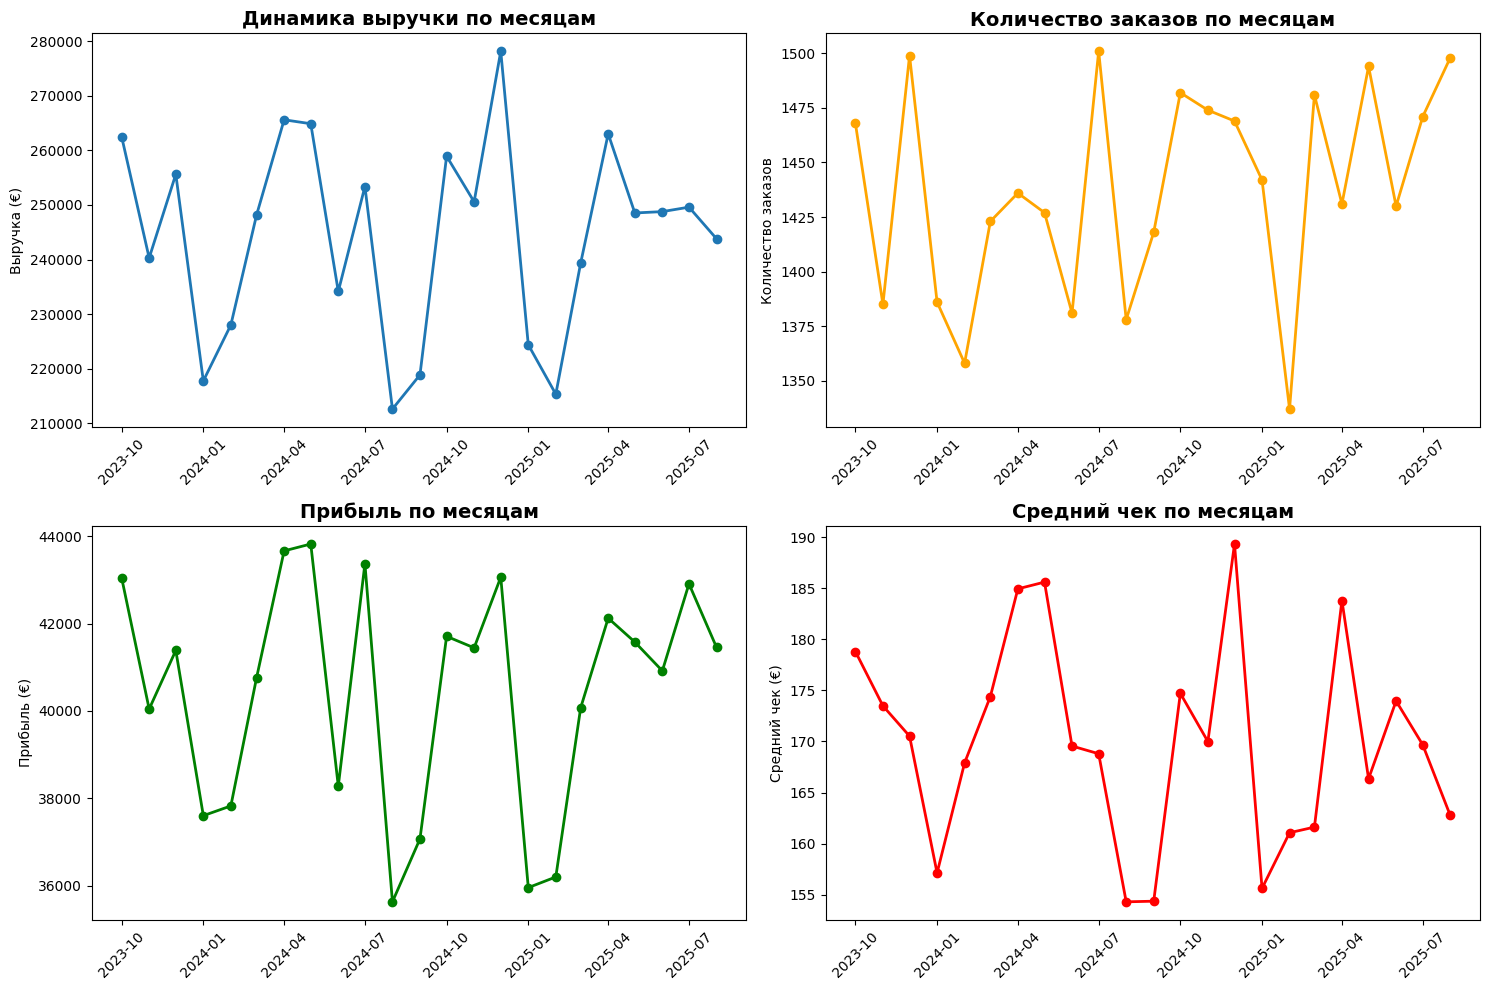

In [22]:
# Вычисляем средний чек ДО фильтрации
monthly_sales['avg_order_value'] = monthly_sales['total_amount'] / monthly_sales['order_id']

# Визуализация трендов продаж (исключая неполные первый и последний месяцы)
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Исключаем первый и последний месяцы как неполные
filtered_sales = monthly_sales.iloc[1:-1]

# График выручки по месяцам
axes[0, 0].plot(filtered_sales['order_date'], filtered_sales['total_amount'], marker='o', linewidth=2)
axes[0, 0].set_title('Динамика выручки по месяцам', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Выручка (€)')
axes[0, 0].tick_params(axis='x', rotation=45)

# График количества заказов по месяцам
axes[0, 1].plot(filtered_sales['order_date'], filtered_sales['order_id'], marker='o', color='orange', linewidth=2)
axes[0, 1].set_title('Количество заказов по месяцам', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Количество заказов')
axes[0, 1].tick_params(axis='x', rotation=45)

# График прибыли по месяцам
axes[1, 0].plot(filtered_sales['order_date'], filtered_sales['profit_margin'], marker='o', color='green', linewidth=2)
axes[1, 0].set_title('Прибыль по месяцам', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Прибыль (€)')
axes[1, 0].tick_params(axis='x', rotation=45)

# График среднего чека по месяцам
axes[1, 1].plot(filtered_sales['order_date'], filtered_sales['avg_order_value'], marker='o', color='red', linewidth=2)
axes[1, 1].set_title('Средний чек по месяцам', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Средний чек (€)')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

- **Рост продаж** с сентября 2023 по сентябрь 2025
- **Выраженная сезонность**: пики в октябре-декабре, спады в январе-феврале

### АНАЛИЗ КАТЕГОРИЙ ТОВАРОВ

In [25]:
# Агрегация данных по категориям
category_analysis = df.groupby('category').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'profit_margin': 'sum',
    'returned': lambda x: (x == 'Yes').sum(),
    'price': 'mean'}).reset_index()

category_analysis.columns = ['category', 'orders_count', 'total_revenue', 'total_profit', 'returns_count', 'avg_price']
category_analysis['return_rate'] = category_analysis['returns_count'] / category_analysis['orders_count']
category_analysis['avg_profit_per_order'] = category_analysis['total_profit'] / category_analysis['orders_count']

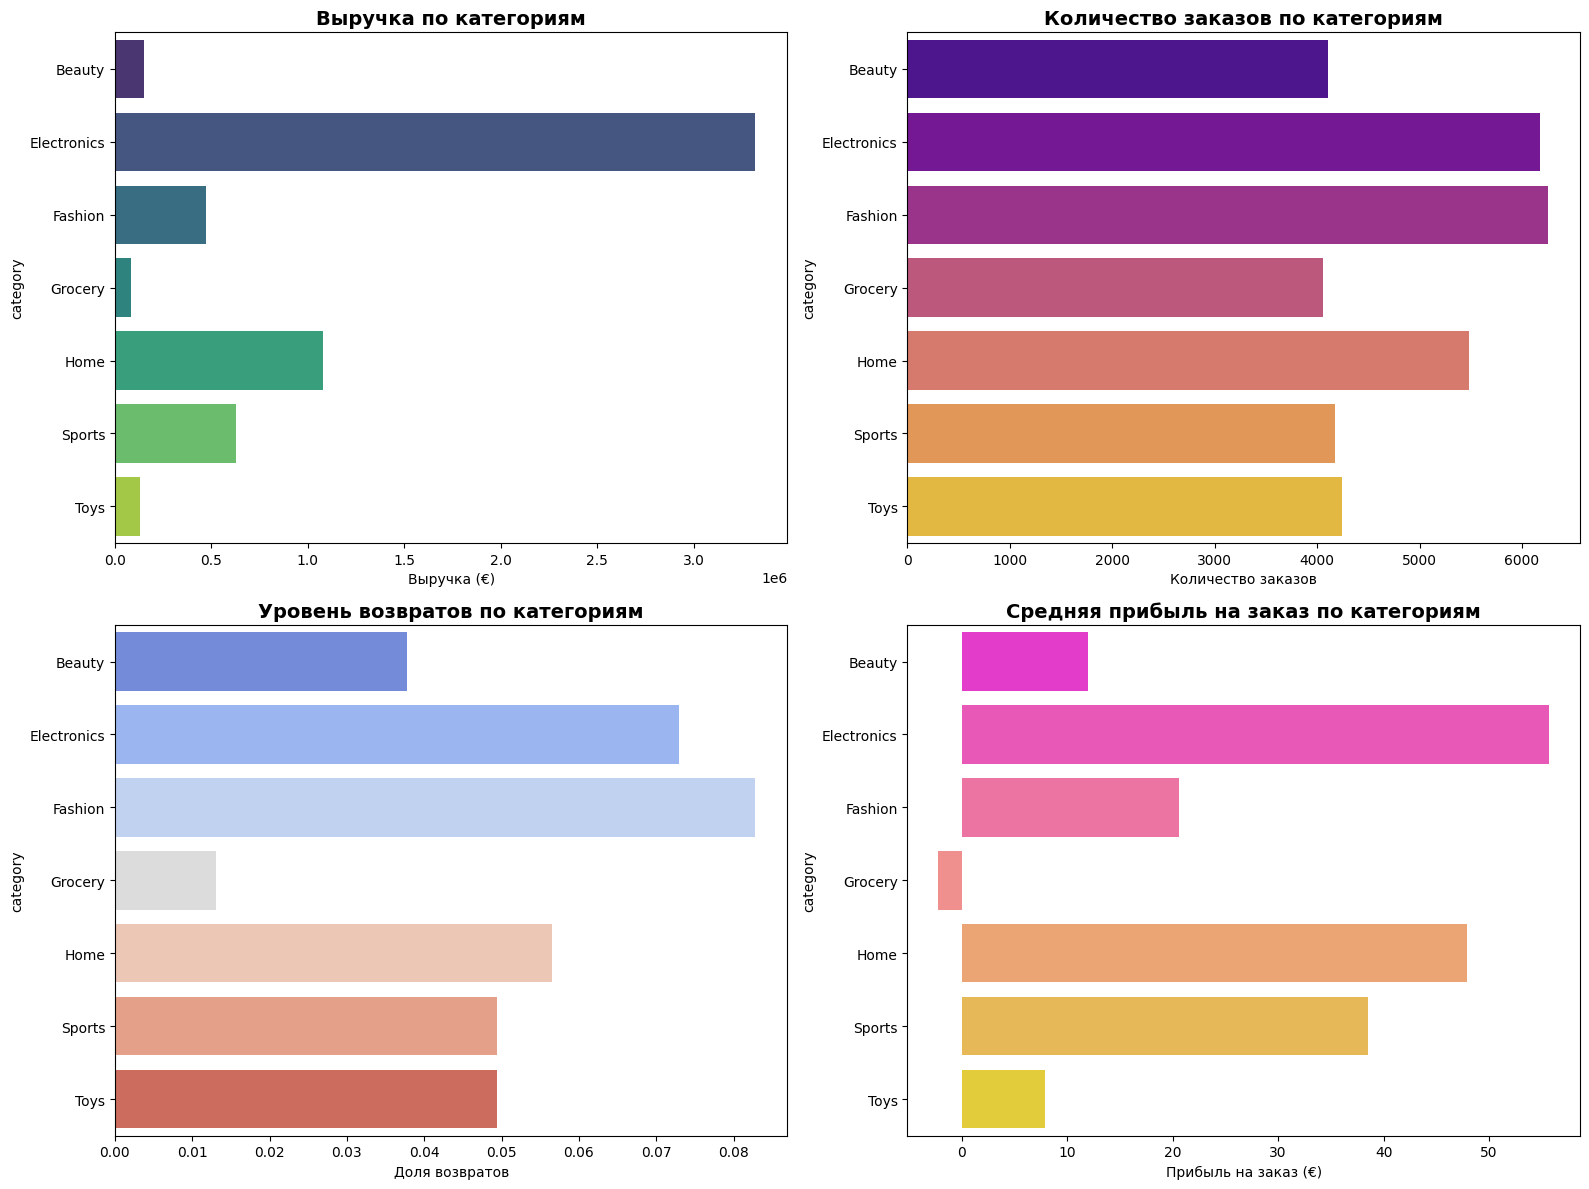

In [26]:
# Визуализация анализа категорий
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Выручка по категориям
sns.barplot(data=category_analysis, x='total_revenue', y='category', hue='category', ax=axes[0, 0], palette='viridis')
axes[0, 0].set_title('Выручка по категориям', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Выручка (€)')

# Количество заказов по категориям
sns.barplot(data=category_analysis, x='orders_count', y='category', hue='category', ax=axes[0, 1], palette='plasma')
axes[0, 1].set_title('Количество заказов по категориям', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Количество заказов')

# Уровень возвратов по категориям
sns.barplot(data=category_analysis, x='return_rate', y='category', hue='category', ax=axes[1, 0], palette='coolwarm')
axes[1, 0].set_title('Уровень возвратов по категориям', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Доля возвратов')

# Средняя прибыль на заказ по категориям
sns.barplot(data=category_analysis, x='avg_profit_per_order', y='category', hue='category', ax=axes[1, 1], palette='spring')
axes[1, 1].set_title('Средняя прибыль на заказ по категориям', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Прибыль на заказ (€)')

plt.tight_layout()

- **Electronics** — лидер по выручке и числу заказов; высокая средняя прибыль на заказ
  
- **Home** — вторая по выручке, умеренное число заказов, высокая прибыль на заказ

- **Fashion** — много заказов, но **высокий уровень возвратов** и низкая прибыль на заказ

- **Grocery** — низкая выручка и прибыль, но очень низкий уровень возвратов

- **Toys / Beauty / Sports** — небольшие объёмы и низкая прибыль

### АНАЛИЗ ВОЗВРАТОВ

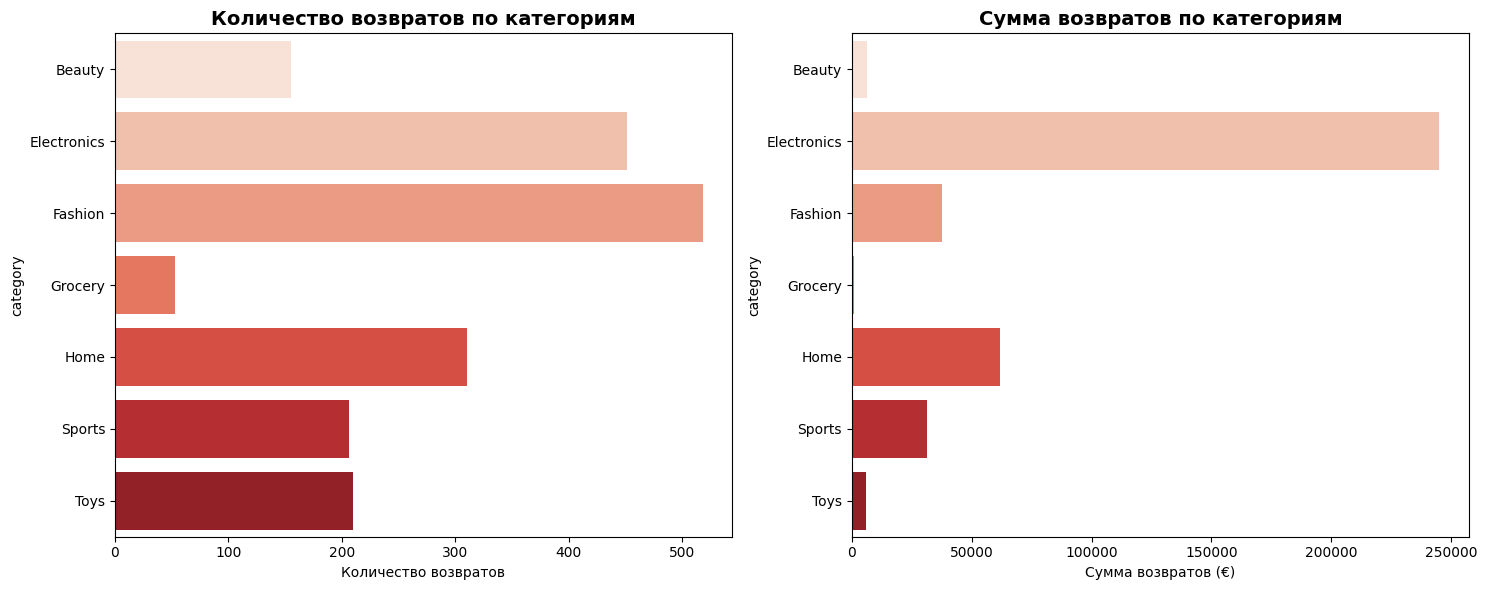

In [29]:
# Детальный анализ возвратов
returns_analysis = df[df['returned'] == 'Yes'].groupby('category').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'price': 'mean',
    'delivery_time_days': 'mean'}).reset_index()

returns_analysis.columns = ['category', 'returns_count', 'total_returned_amount', 'avg_price', 'avg_delivery_time']

returns_analysis.sort_values('returns_count', ascending=False)

# Визуализация анализа возвратов
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Количество возвратов по категориям
sns.barplot(data=returns_analysis, x='returns_count', y='category', ax=axes[0], 
            hue='category', palette='Reds', legend=False)
axes[0].set_title('Количество возвратов по категориям', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Количество возвратов')

# Сумма возвратов по категориям
sns.barplot(data=returns_analysis, x='total_returned_amount', y='category', ax=axes[1],
            hue='category', palette='Reds', legend=False)
axes[1].set_title('Сумма возвратов по категориям', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Сумма возвратов (€)')

plt.tight_layout()

- **Electronics** Аномальная сумма возвратов объясняется дорогими вещами, и является одной из самых популярных категорий 

- **Beauty / Grocery / Sports / Toys** - минимальные показатели возвратов

### АНАЛИЗ ГЕОГРАФИЧЕСКОГО РАСПРЕДЕЛЕНИЯ

In [32]:
region_analysis = df.groupby('region').agg({
    'order_id': 'count',
    'total_amount': 'sum',
    'profit_margin': 'sum',
    'returned': lambda x: (x == 'Yes').sum(),
    'delivery_time_days': 'mean'}).reset_index()

region_analysis.columns = ['region', 'orders_count', 'total_revenue', 'total_profit', 'returns_count', 'avg_delivery_time']
region_analysis['return_rate'] = region_analysis['returns_count'] / region_analysis['orders_count']

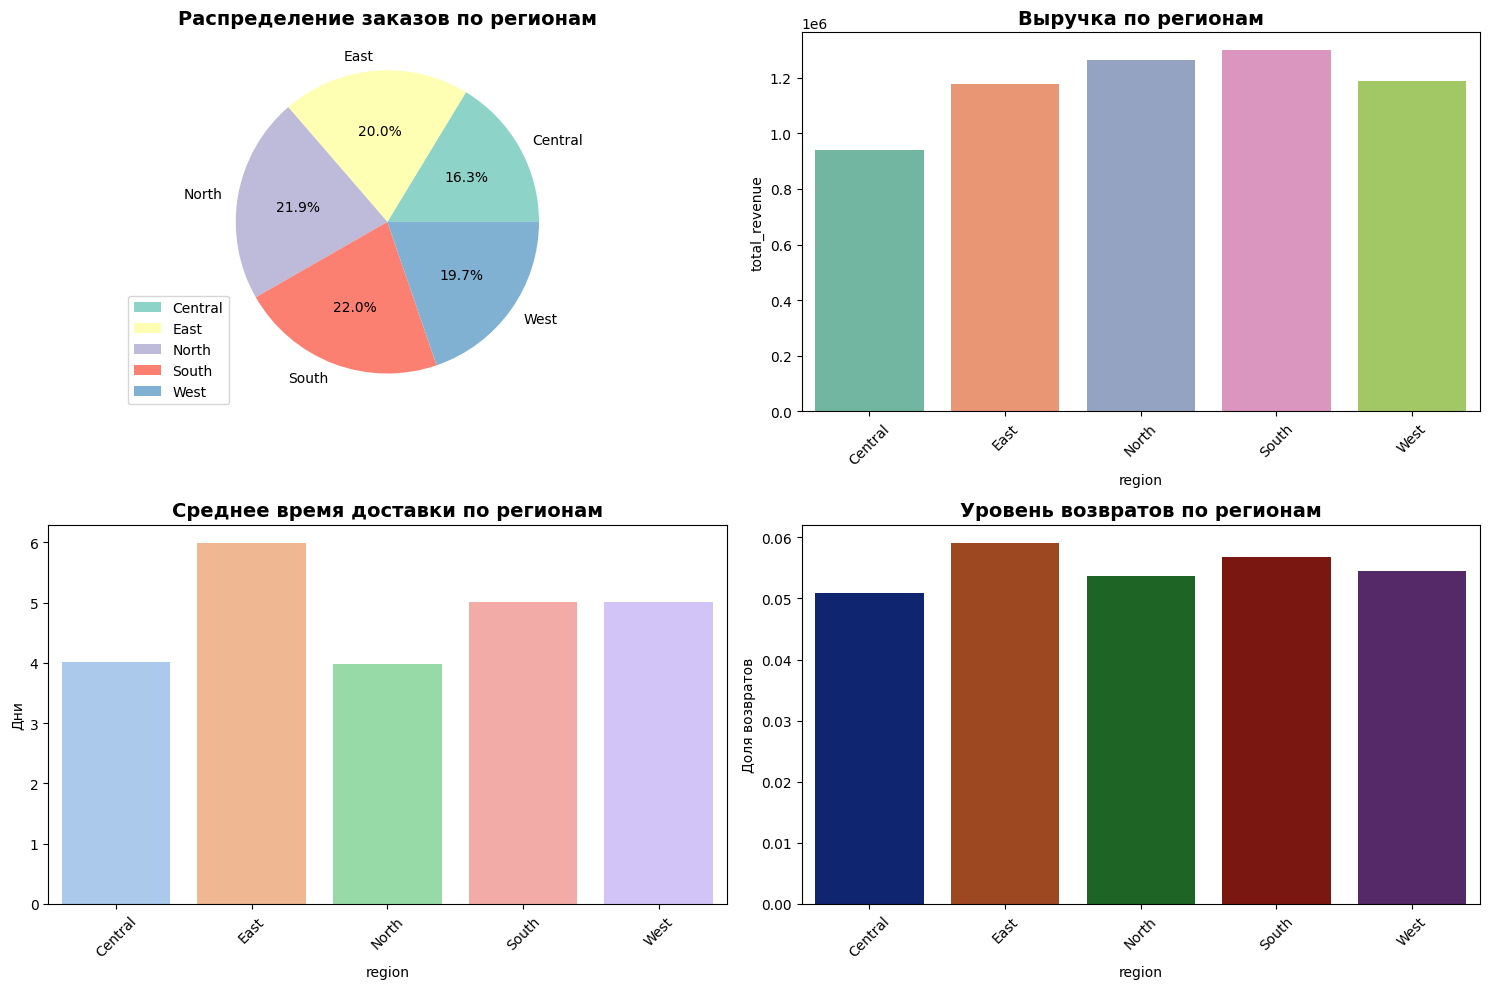

In [33]:
# Визуализация регионального анализа
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Распределение заказов по регионам
region_analysis.plot.pie(y='orders_count', labels=region_analysis['region'], autopct='%1.1f%%', 
                         ax=axes[0, 0], colors=sns.color_palette("Set3"))
axes[0, 0].set_title('Распределение заказов по регионам', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('')
axes[0, 0].legend(bbox_to_anchor=(0.1, 0), loc='lower right')

# Выручка по регионам
sns.barplot(data=region_analysis, x='region', y='total_revenue', hue='region', 
            ax=axes[0, 1], palette='Set2', legend=False)
axes[0, 1].set_title('Выручка по регионам', fontsize=14, fontweight='bold')
axes[0, 1].tick_params(axis='x', rotation=45)

# Время доставки по регионам
sns.barplot(data=region_analysis, x='region', y='avg_delivery_time', hue='region',
            ax=axes[1, 0], palette='pastel', legend=False)
axes[1, 0].set_title('Среднее время доставки по регионам', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Дни')
axes[1, 0].tick_params(axis='x', rotation=45)

# Уровень возвратов по регионам
sns.barplot(data=region_analysis, x='region', y='return_rate', hue='region',
            ax=axes[1, 1], palette='dark', legend=False)
axes[1, 1].set_title('Уровень возвратов по регионам', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Доля возвратов')
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()

- **Central** - меньше всего заказов из данного региона. От сюда самые низкие показатели по всем аспектам
- **East** - самая долгая доставка и самый высокий возврат
- **North / South / West** - похожие регионы, ничем не выделяются

### КОРРЕЛЯЦИОННЫЙ АНАЛИЗ

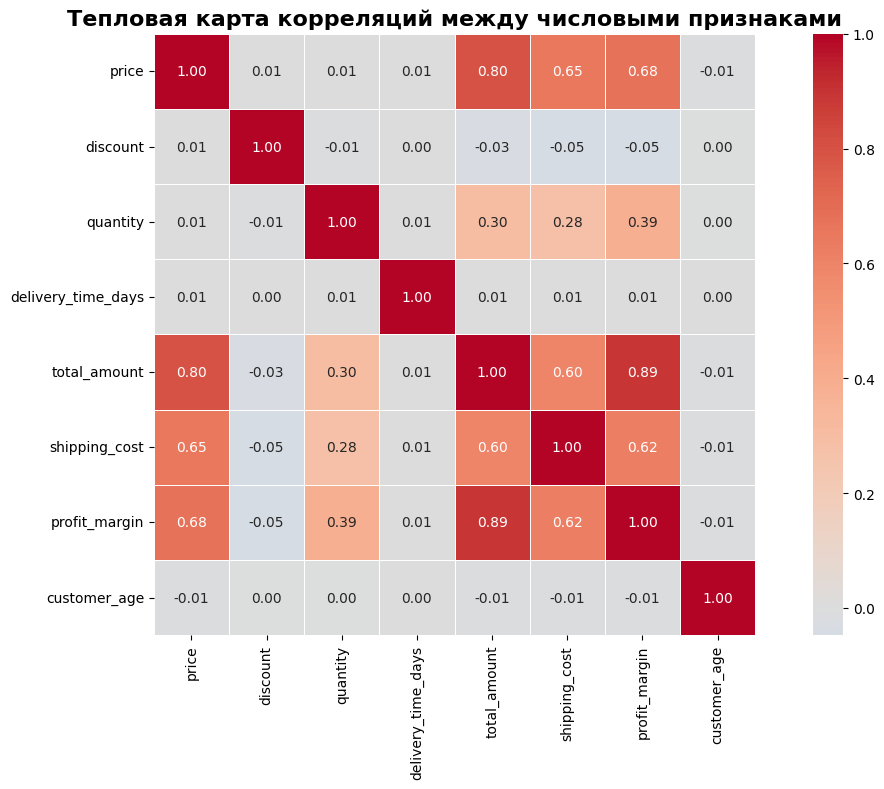

In [36]:
# Выбираем числовые колонки для корреляционного анализа
numeric_columns = ['price', 'discount', 'quantity', 'delivery_time_days', 
                   'total_amount', 'shipping_cost', 'profit_margin', 'customer_age']

# Создаем матрицу корреляций
correlation_matrix = df[numeric_columns].corr()

# Визуализация тепловой карты корреляций
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, fmt='.2f')
plt.title('Тепловая карта корреляций между числовыми признаками', fontsize=16, fontweight='bold')
plt.tight_layout()

- **profit_margian** - напрясую зависит от `price`, `quantity` и `shiping_cost`
- **shipping_cost <---> price (0.65)** - дорогие товары дороже доставлять
- **discount** не влияет на выручку и прибыль

**Цена товара - главный драйвер выручки и прибыли**, а скидки практически не работают.

# Этап 3: RFM-анализ и Кластеризация

### RFM-АНАЛИЗ: РАСЧЕТ МЕТРИК

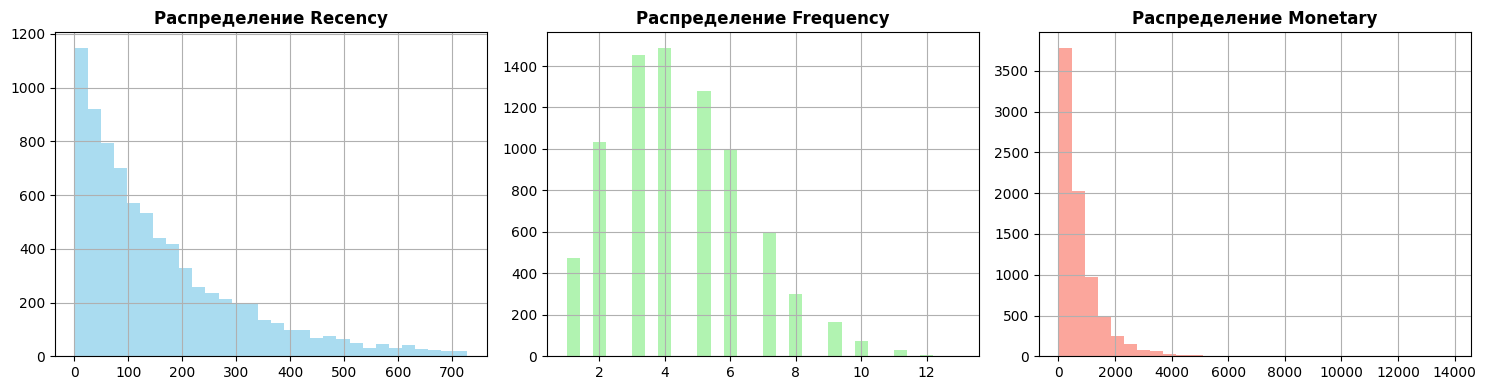

In [40]:
# Находим последнюю дату в данных для расчета Recency
latest_date = df['order_date'].max()

# Считаем RFM-метрики для каждого клиента
rfm_df = df.groupby('customer_id').agg({
    'order_date': lambda x: (latest_date - x.max()).days, # Recency
    'order_id': 'count', # Frequency  
    'total_amount': 'sum' # Monetary
}).reset_index()

# Переименовываем колонки
rfm_df.columns = ['customer_id', 'recency', 'frequency', 'monetary']

# Анализ распределения RFM-метрик перед преобразованием
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rfm_df['recency'].hist(ax=axes[0], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Распределение Recency', fontweight='bold')

rfm_df['frequency'].hist(ax=axes[1], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Распределение Frequency', fontweight='bold')

rfm_df['monetary'].hist(ax=axes[2], bins=30, alpha=0.7, color='salmon')
axes[2].set_title('Распределение Monetary', fontweight='bold')

plt.tight_layout()

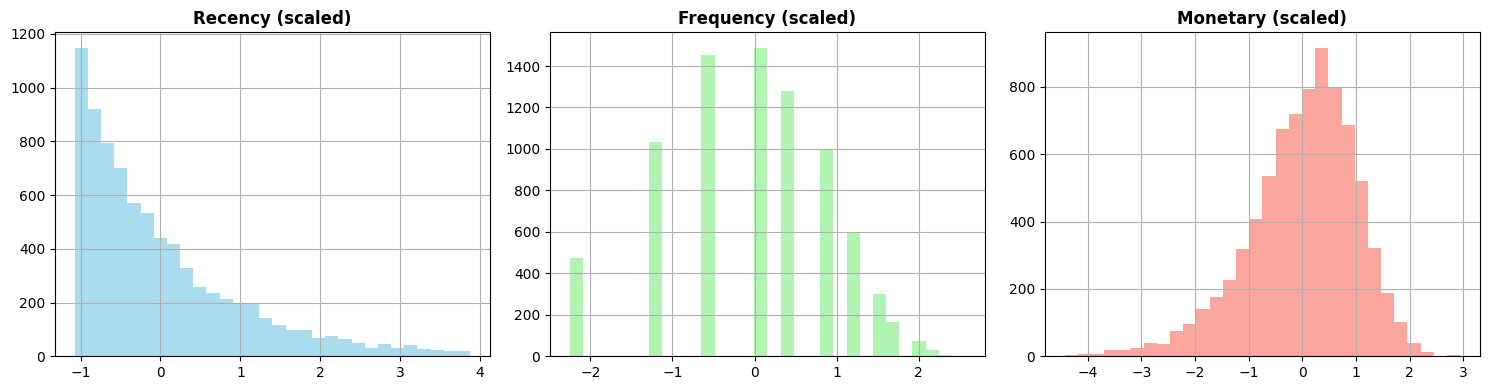

In [41]:
from sklearn.preprocessing import StandardScaler

rfm_scaled = rfm_df.copy()

# Логарифмируем Frequency и Monetary для нормализации распределения
rfm_scaled['frequency_log'] = np.log1p(rfm_scaled['frequency'])
rfm_scaled['monetary_log'] = np.log1p(rfm_scaled['monetary'])

# Масштабируем все признаки
scaler = StandardScaler()
rfm_scaled[['recency_scaled', 'frequency_scaled', 'monetary_scaled']] = scaler.fit_transform(
    rfm_scaled[['recency', 'frequency_log', 'monetary_log']])


fig, axes = plt.subplots(1, 3, figsize=(15, 4))

rfm_scaled['recency_scaled'].hist(ax=axes[0], bins=30, alpha=0.7, color='skyblue')
axes[0].set_title('Recency (scaled)', fontweight='bold')

rfm_scaled['frequency_scaled'].hist(ax=axes[1], bins=30, alpha=0.7, color='lightgreen')
axes[1].set_title('Frequency (scaled)', fontweight='bold')

rfm_scaled['monetary_scaled'].hist(ax=axes[2], bins=30, alpha=0.7, color='salmon')
axes[2].set_title('Monetary (scaled)', fontweight='bold')

plt.tight_layout()

### ОПРЕДЕЛЕНИЕ ОПТИМАЛЬНОГО ЧИСЛА КЛАСТЕРОВ

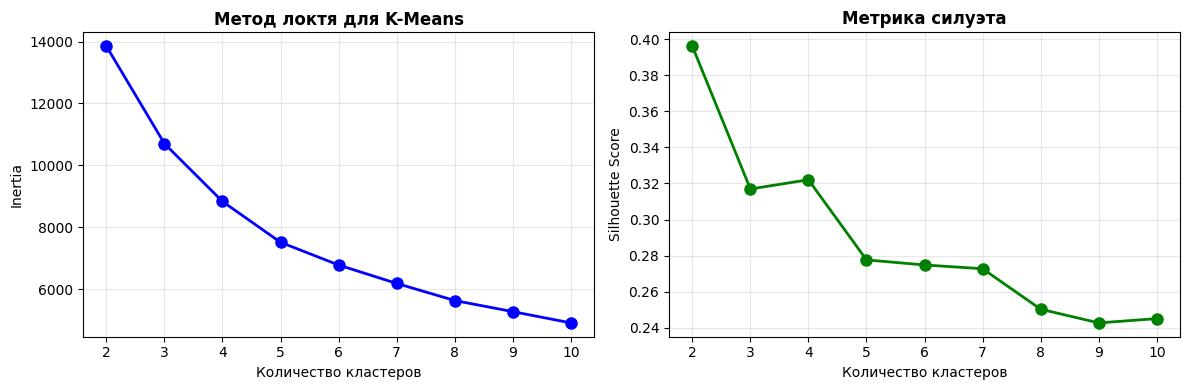

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

X = rfm_scaled[['recency_scaled', 'frequency_scaled', 'monetary_scaled']]

# Метод локтя для определения оптимального k
inertia = []
silhouette_scores = []

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X, kmeans.labels_))

# Визуализация метода локтя
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), inertia, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('Inertia')
plt.title('Метод локтя для K-Means', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(range(2, 11), silhouette_scores, 'go-', linewidth=2, markersize=8)
plt.xlabel('Количество кластеров')
plt.ylabel('Silhouette Score')
plt.title('Метрика силуэта', fontweight='bold')
plt.grid(True, alpha=0.3)

plt.tight_layout()

Выберем $k = 5$, поскольку на левом графике, в данной точке, находится так называемый "локоть" 

Так же на правом графике в точке 5 видин значительный перепад, после которого начинается полотно

### КЛАСТЕРИЗАЦИЯ K-MEANS

In [46]:
optimal_k = 5

kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
rfm_scaled['cluster'] = kmeans.fit_predict(X)

# Добавляем кластеры к исходным RFM данным
rfm_df['cluster'] = rfm_scaled['cluster']

print("Размеры кластеров:")
rfm_df['cluster'].value_counts().sort_index()

Размеры кластеров:


cluster
0    2492
1     588
2    1071
3    1331
4    2421
Name: count, dtype: int64

### АНАЛИЗ КЛАСТЕРОВ

In [48]:
# Анализируем характеристики кластеров
cluster_analysis = rfm_df.groupby('cluster').agg({
    'recency': ['mean', 'std'],
    'frequency': ['mean', 'std'], 
    'monetary': ['mean', 'std'],
    'customer_id': 'count'}).round(2)

cluster_analysis.columns = ['recency_mean', 'recency_std', 
                           'frequency_mean', 'frequency_std',
                           'monetary_mean', 'monetary_std', 
                           'customers_count']

cluster_analysis

,recency_mean,recency_std,frequency_mean,frequency_std,monetary_mean,monetary_std,customers_count
cluster,,,,,,,
0,81.81,56.81,4.15,1.06,470.80,322.88,2492
1,494.73,115.62,1.66,0.71,159.58,208.19,588
2,138.48,86.94,2.22,0.78,120.25,104.44,1071
3,309.31,86.80,3.68,1.21,734.60,649.07,1331
4,80.11,64.92,6.56,1.56,1442.26,1029.65,2421


- **Ксластер 0:** Недавние покупки, средняя частота и сумма. Надежные постоянные клиенты
- **Ксластер 1:** Очень давние покупки, низкая частота и сумма. Практически потерянные клиенты
- **Ксластер 2:** Недавние покупки, но низкие частота и сумма. Новые клиенты
- **Ксластер 3:** Высокие чеки, но покупали давно. "Спящие" крупные клиенты
- **Ксластер 4:** Самые лучшие по всем показателям: покупают часто, недавно и на большие суммы

In [50]:
# Объединяем RFM кластеры с агрегированными данными клиентов
customer_segments = customer_agg.merge(
    rfm_df[['customer_id', 'cluster']], 
    on='customer_id', 
    how='left')

# Добавляем названия сегментов на основе вашего анализа
segment_names = {0: 'Надежные постоянные',
                 1: 'Почти потерянные', 
                 2: 'Новые клиенты',
                 3: 'Спящие крупные',
                 4: 'VIP клиенты'}

customer_segments['segment'] = customer_segments['cluster'].map(segment_names)

# Анализируем различия между сегментами
segment_comparison = customer_segments.groupby('segment').agg({
    'total_orders': 'mean',
    'total_spent': 'mean',
    'avg_order_value': 'mean',
    'avg_discount': 'mean',
    'returns_count': 'mean',
    'return_rate': 'mean',
    'avg_delivery_time': 'mean',
    'total_shipping_cost': 'mean',
    'customer_age': 'mean',
    'customer_id': 'count'}).round(2)

segment_comparison = segment_comparison.rename(columns={'customer_id': 'count'})
segment_comparison

,total_orders,total_spent,avg_order_value,avg_discount,returns_count,return_rate,avg_delivery_time,total_shipping_cost,customer_age,count
segment,,,,,,,,,,
VIP клиенты,6.56,1442.26,237.02,0.05,0.37,0.06,4.83,42.19,43.37,2421
Надежные постоянные,4.15,470.80,129.68,0.05,0.23,0.05,4.79,24.43,43.88,2492
Новые клиенты,2.22,120.25,64.90,0.05,0.12,0.06,4.81,11.33,44.00,1071
Почти потерянные,1.66,159.58,112.00,0.05,0.07,0.04,4.85,9.38,44.29,588
Спящие крупные,3.68,734.60,229.71,0.05,0.21,0.06,4.82,23.73,43.49,1331


- **VIP клиенты** — самые ценные: совершают больше всего заказов `6.56` и тратят значительно больше всех `1442.26`
- **Надежные постоянные** — ядро бизнеса: стабильные средние показатели по всем метрикам, вторая по размеру группа. Основа стабильного дохода.
- **Новые клиенты** — требуют развития: у них низкие показатели по всем метрикам, что ожидаемо. Важно перевести их в категорию "Надежных".
- **Почти потерянные** — наименее активные: у них наименьшее число заказов `1.66` и низкая вовлеченность, но высокий средний чек `112.00`.
- **Спящие крупные** — клиенты с высоким потенциалом: у них высокий средний чек `229.71`, но низкая частота заказов. Это возможность для реактивации.

Скидки и логистика не являются ключевыми различиями между сегментами (средний дисконт и время доставки практически одинаковы).

Возраст клиентов во всех сегментах практически идентичен (~44 года) и не является определяющим фактором.

### АНАЛИЗ ПРИЧИН ОТТОКА - СРАВНЕНИЕ "ПОЧТИ ПОТЕРЯННЫХ" С ДРУГИМИ СЕГМЕНТАМИ

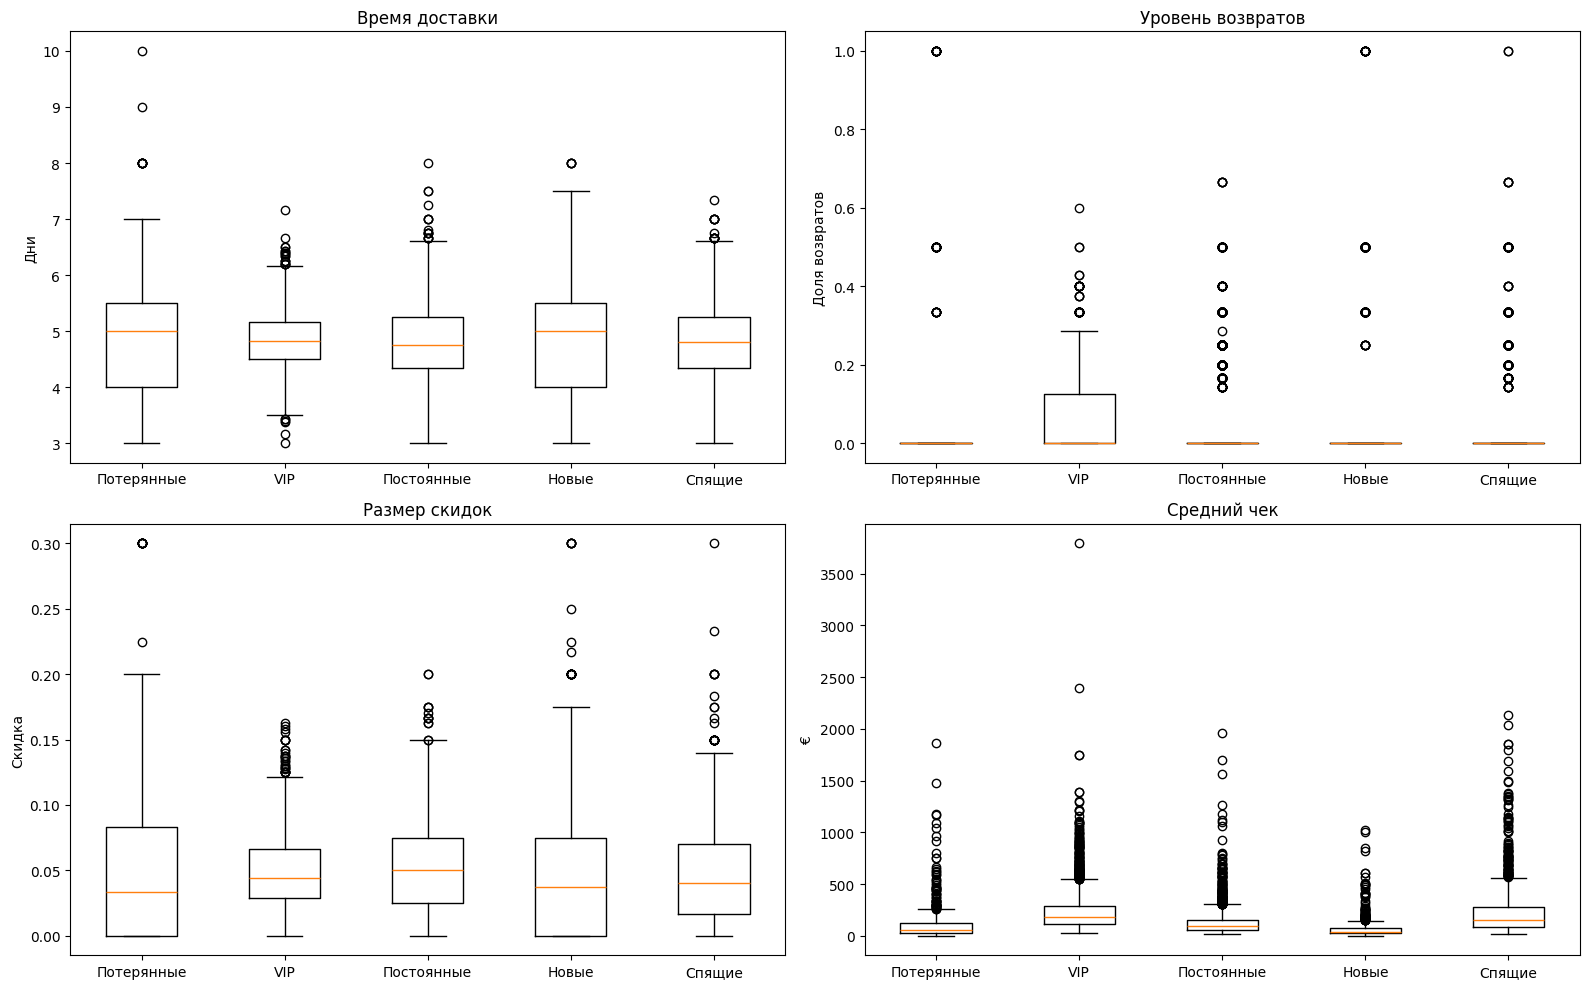

In [53]:
# Анализ причин оттока - сравнение всех сегментов
segments = {'Потерянные': customer_segments[customer_segments['segment'] == 'Почти потерянные'],
            'VIP': customer_segments[customer_segments['segment'] == 'VIP клиенты'],
            'Постоянные': customer_segments[customer_segments['segment'] == 'Надежные постоянные'],
            'Новые': customer_segments[customer_segments['segment'] == 'Новые клиенты'],
            'Спящие': customer_segments[customer_segments['segment'] == 'Спящие крупные']}

fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Время доставки
delivery_data = [segments[name]['avg_delivery_time'] for name in segments]
axes[0, 0].boxplot(delivery_data)
axes[0, 0].set_xticklabels(segments.keys())
axes[0, 0].set_title('Время доставки')
axes[0, 0].set_ylabel('Дни')

# Уровень возвратов
return_data = [segments[name]['return_rate'] for name in segments]
axes[0, 1].boxplot(return_data)
axes[0, 1].set_xticklabels(segments.keys())
axes[0, 1].set_title('Уровень возвратов')
axes[0, 1].set_ylabel('Доля возвратов')

# Размер скидок
discount_data = [segments[name]['avg_discount'] for name in segments]
axes[1, 0].boxplot(discount_data)
axes[1, 0].set_xticklabels(segments.keys())
axes[1, 0].set_title('Размер скидок')
axes[1, 0].set_ylabel('Скидка')

# Средний чек
order_value_data = [segments[name]['avg_order_value'] for name in segments]
axes[1, 1].boxplot(order_value_data)
axes[1, 1].set_xticklabels(segments.keys())
axes[1, 1].set_title('Средний чек')
axes[1, 1].set_ylabel('€')

plt.tight_layout()

## Выводы по всем сегментам:

### Время доставки
- **Потерянные и Спящие** - максимальное время доставки
- **VIP** - минимальное время доставки  
- **Новые клиенты** - среднее время доставки

### Уровень возвратов
- **Потерянные** - катастрофически высокие возвраты
- **Новые клиенты** - высокие возвраты
- **VIP и Постоянные** - минимальные возвраты

### Размер скидок
- **VIP и Спящие** - максимальные скидки
- **Потерянные** - минимальные скидки
- **Новые клиенты** - средние скидки

### Средний чек
- **VIP** - максимальные чеки
- **Спящие** - высокие чеки (но не покупают)
- **Потерянные** - минимальные чеки

## Ключевые инсайты:
1. **Потерянные клиенты** - плохо по всем метрикам
2. **Спящие клиенты** - ценны, но неактивны  
3. **Новые клиенты** - риск ухода из-за возвратов
4. **VIP клиенты** - идеальное обслуживание

## Рекомендации для компании

### Что пересмотреть в системе:
- Оптимизировать логистику
- Пересмотреть политику скидок 
- Улучшить контроль качества
  
### Приоритетные группы:
`Спящие`  `Новые`  `Потерянные` 
тавка для следующего заказа

### Вывод по работе:
RFM-анализ выявил четкие сегменты клиентов. Основные проблемы - долгая доставка и высокие возвраты. VIP-клиенты получают лучшее обслуживание, что создает неравенство. Оптимизация логистики и пересмотр скидочной политики помогут снизить отток.